In [1]:
%run FUNCIONES_GENERALES.ipynb

/home/khaosdev/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/khaosdev/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt

# skforecast
import skforecast
import pandas as pd
from sklearn import metrics
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from pmdarima import auto_arima 

import warnings
warnings.filterwarnings('once')

In [13]:
def prediccion_autorregresivos(datos,datos_train,datos_test,fin_val):
    
    # Grid search
    forecaster = ForecasterSarimax(
                    regressor=Sarimax(
                                    order=(1, 1, 1), # Placeholder replaced in the grid search
                                    maxiter=500
                                )
                )

    param_grid = {
        'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1), (1 ,1 ,2), ( 2, 1, 2),(0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 0, 1), (2, 0, 1), (1 ,0 ,2), ( 2, 0, 2) ],
        'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
        'trend': [None]
    }

    resultados_grid = grid_search_sarimax(
                            forecaster            = forecaster,
                            y                     = datos['Precio'],
                            param_grid            = param_grid,
                            steps                 = 12,
                            refit                 = True,
                            metric                = 'mean_absolute_error',
                            initial_train_size    = len(datos_train),
                            fixed_train_size      = False,
                            return_best           = False,
                            n_jobs                = 'auto',
                            suppress_warnings_fit = True,
                            verbose               = False,
                            show_progress         = True
                    )
    r=resultados_grid.index[0]
    

    # Predicciones de backtesting con el mejor modelo según el grid search
    # ==============================================================================
    forecaster_1 = ForecasterSarimax( regressor=Sarimax(order=resultados_grid.order[r], seasonal_order=resultados_grid.seasonal_order[r], maxiter=500),
                    )

    metrica_m1, predicciones_m1 = backtesting_sarimax(
                                            forecaster            = forecaster_1,
                                            y                     = datos['Precio'],
                                            initial_train_size    = len(datos.loc[:fin_val]),
                                            steps                 = 36,
                                            metric                = 'mean_absolute_error',
                                            refit                 = True,
                                            n_jobs                = "auto",
                                            suppress_warnings_fit = True,
                                            verbose               = False,
                                            show_progress         = True
                                        )

    
    # Comparación de métricas
    # ==============================================================================
    print("Metrica (mean absolute error): ")
    print(metrics.mean_squared_error(datos_test, predicciones_m1))

    fig, ax = plt.subplots(figsize=(6, 3))
    datos.loc[fin_val:].plot(ax=ax, label='test')
    predicciones_m1 = predicciones_m1.rename(columns={'pred': 'grid search'})
    predicciones_m1.plot(ax=ax)
    ax.set_title('Predicciones de backtesting con un modelo SARIMA')
    ax.legend()
    
 

In [4]:
# Parámetros de los modelos:
paramsD1=[1,[350,23]]
paramsD2=[2,[20,0.6,200]]
params_ARMA1 = [250,0.6,3, [0.12,0.24],[0.3],[]]
params_ARMA2 = [270,1.5,0, [0.8],[0.3,0.25],[]]
params_per1= [1,1,[200,10],12]
params_per2= [2,1,[250,13],3]
params_tend1 = [[200,0.3],1,0.3]
params_tend2 = [[150,-4,0.2],2,0.15]

In [5]:
fecha1='1/1/2012'

In [6]:
fecha2='1/1/2024'

In [7]:
fecha3='1/1/2026'

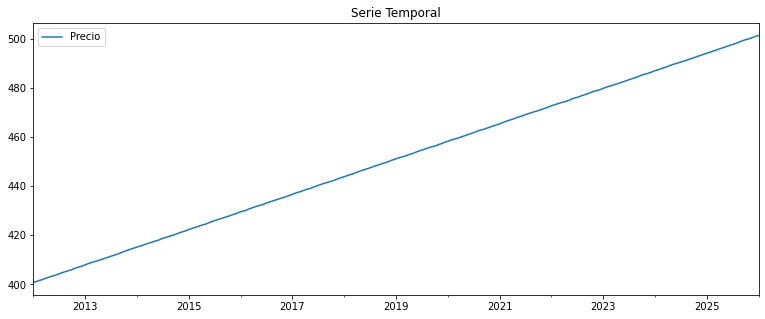

In [8]:
df1 = crear_df_fin_tend_det(fecha1,fecha3,'MS',['Precio'],[400,0.6],1,0.2)

In [9]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df1_train = df1.loc[:fin_train]
df1_test  = df1.loc[fin_train:]

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
0.003839496645686609


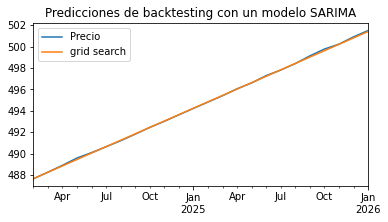

In [14]:
prediccion_autorregresivos(df1,df1_train,df1_test,fin_train)

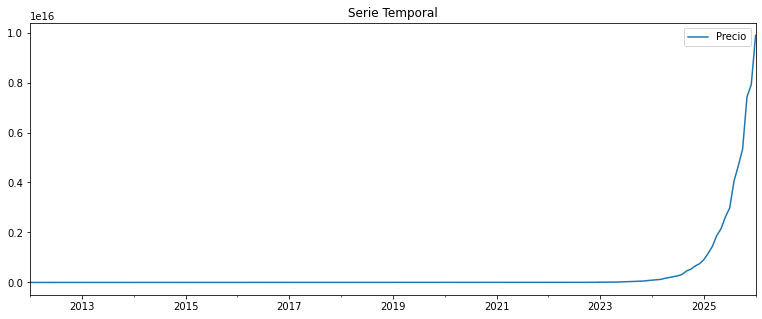

In [17]:
df2 = crear_df_fin_tend_det(fecha1,fecha3,'MS',['Precio'],[3,0.2],3,0.2)

In [18]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df2_train = df2.loc[:fin_train]
df2_test  = df2.loc[fin_train:]

In [20]:
prediccion_autorregresivos(df2,df2_train,df2_test,fin_train)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

LinAlgError: LU decomposition error.

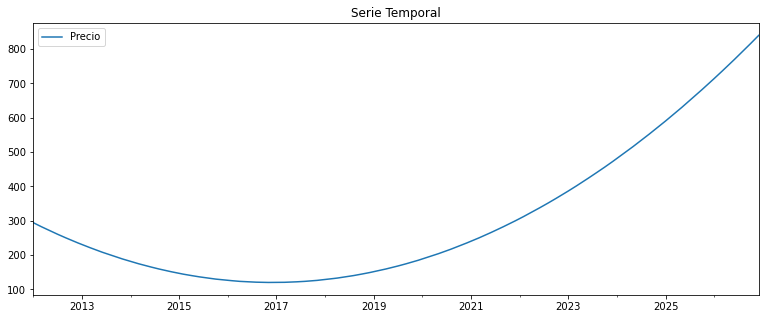

In [21]:
df3 = crear_df_periodos_tend_det(fecha1,180,'MS',['Precio'],[300,-6,0.05],2,0.2)

In [22]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df3_train = df3.loc[:fin_train]
df3_test  = df3.loc[fin_train:]

In [24]:
prediccion_autorregresivos(df3,df3_train,df3_test,fin_train)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

LinAlgError: LU decomposition error.

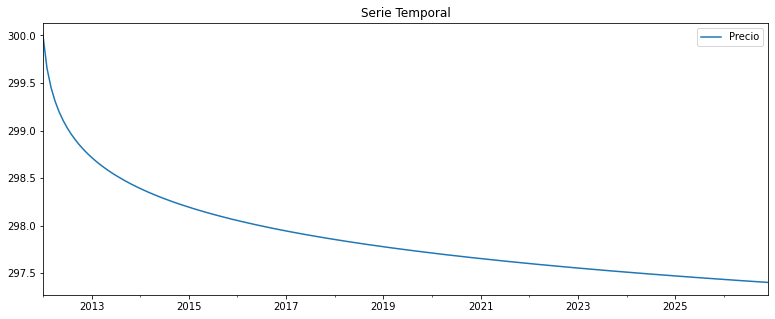

In [25]:
df4 = crear_df_periodos_tend_det(fecha1,180,'MS',['Precio'],[300,-0.5],4,0.2)

In [26]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df4_train = df4.loc[:fin_train]
df4_test  = df4.loc[fin_train:]

prediccion_autorregresivos(df4,df4_train,df4_test,fin_train)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

LinAlgError: LU decomposition error.

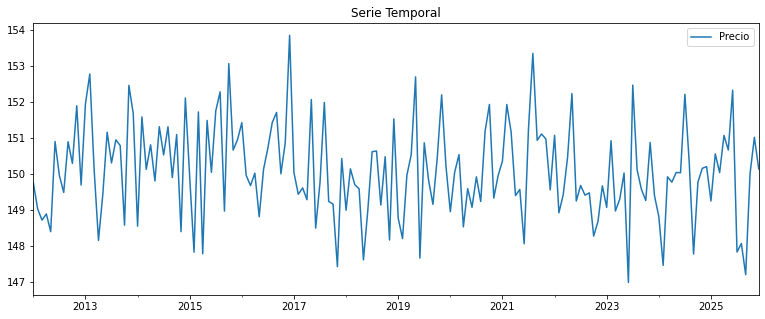

In [27]:
df5=crear_df_fin_datos(fecha1,fecha3,'M',['Precio'],1,[150,1.5])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
1.8108412036224113


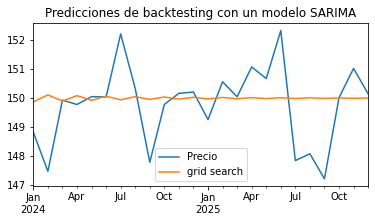

In [28]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df5_train = df5.loc[:fin_train]
df5_test  = df5.loc[fin_train:]

prediccion_autorregresivos(df5,df5_train,df5_test,fin_train)

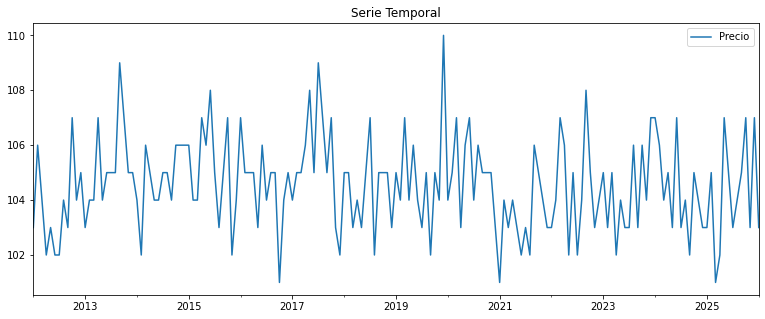

In [29]:
df6=crear_df_fin_datos(fecha1,fecha3,'MS',['Precio'],2,[15,0.3,100])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
2.773143880258845


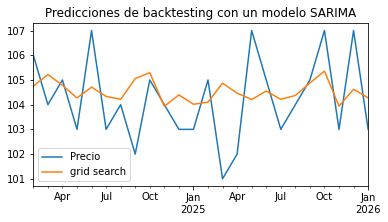

In [30]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df6_train = df6.loc[:fin_train]
df6_test  = df6.loc[fin_train:]

prediccion_autorregresivos(df6,df6_train,df6_test,fin_train)

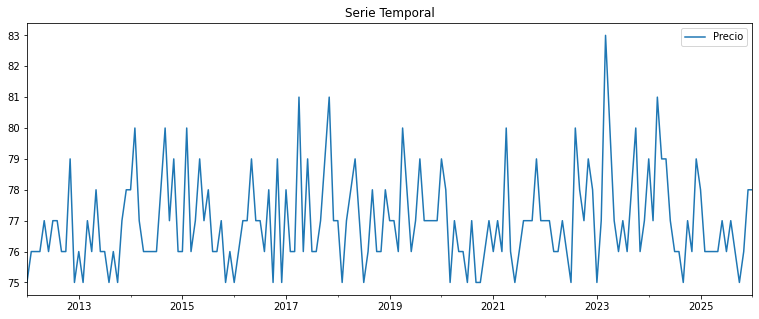

In [31]:
df7=crear_df_fin_datos(fecha1,fecha3,'MS',['Precio'],3,[2,75])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
2.424848444748165


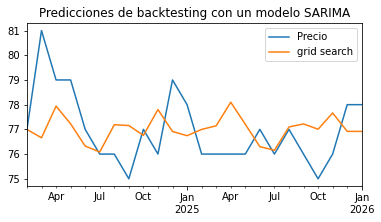

In [32]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df7_train = df7.loc[:fin_train]
df7_test  = df7.loc[fin_train:]

prediccion_autorregresivos(df7,df7_train,df7_test,fin_train)

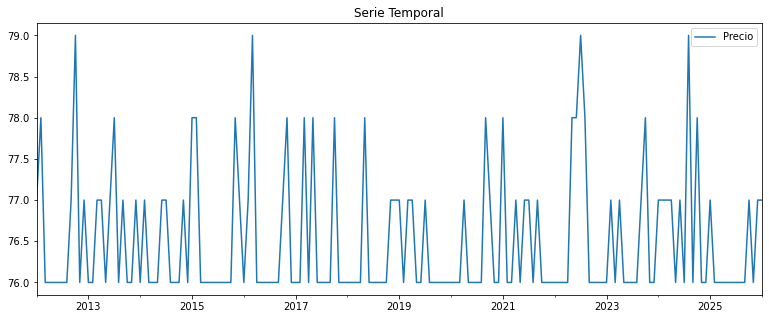

In [33]:
dfg=crear_df_fin_datos(fecha1,fecha3,'MS',['Precio'],4,[0.62,75])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
0.60151944581377


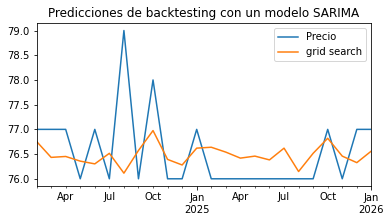

In [34]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
dfg_train = dfg.loc[:fin_train]
dfg_test  = dfg.loc[fin_train:]

prediccion_autorregresivos(dfg,dfg_train,dfg_test,fin_train)

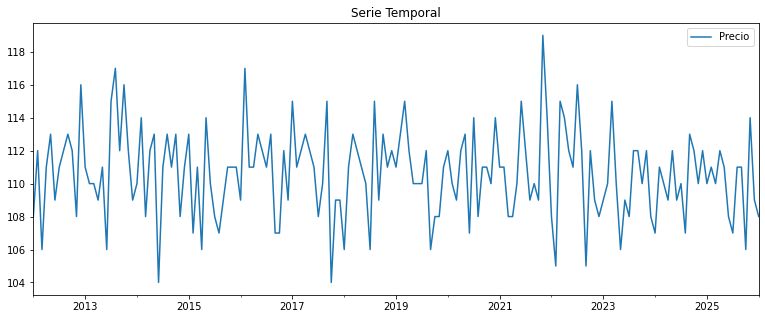

In [35]:
df8=crear_df_fin_datos(fecha1,fecha3,'MS',['Precio'],5,[100,43,55,87])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
3.9577539944955142


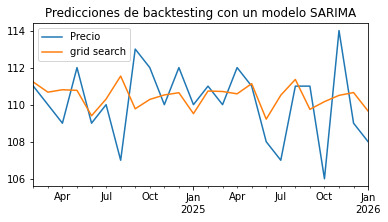

In [36]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df8_train = df8.loc[:fin_train]
df8_test  = df8.loc[fin_train:]

prediccion_autorregresivos(df8,df8_train,df8_test,fin_train)

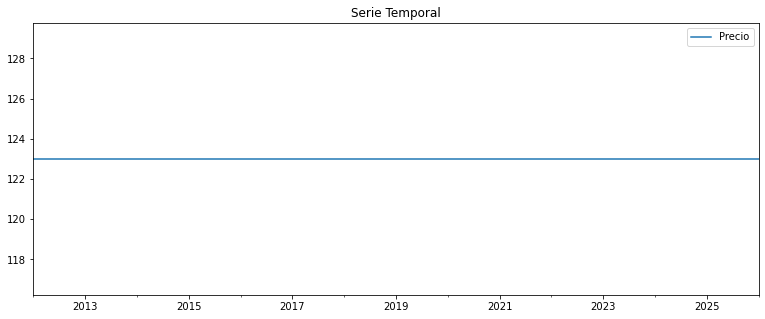

In [37]:
df9=crear_df_fin_datos(fecha1,fecha3,'MS',['Precio'],6,[123])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
0.0


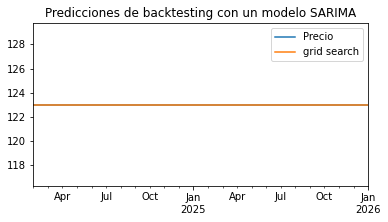

In [39]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df9_train = df9.loc[:fin_train]
df9_test  = df9.loc[fin_train:]

prediccion_autorregresivos(df9,df9_train,df9_test,fin_train)

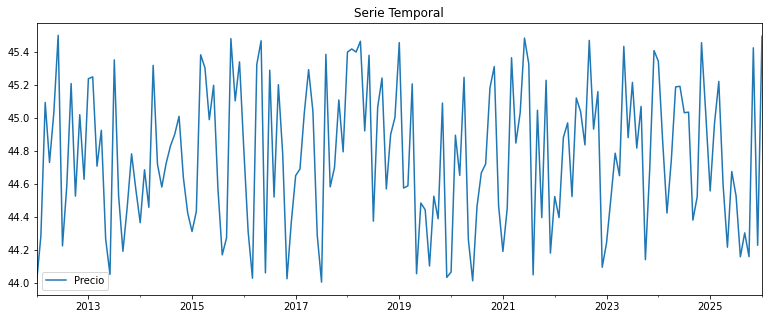

In [40]:
df10=crear_df_fin_datos(fecha1,fecha3,'MS',['Precio'],7,[44,1.5])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
0.17764995821438145


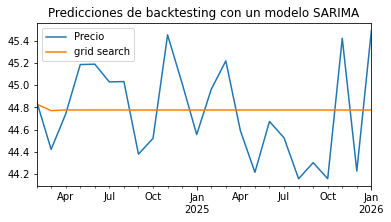

In [41]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df10_train = df10.loc[:fin_train]
df10_test  = df10.loc[fin_train:]

prediccion_autorregresivos(df10,df10_train,df10_test,fin_train)

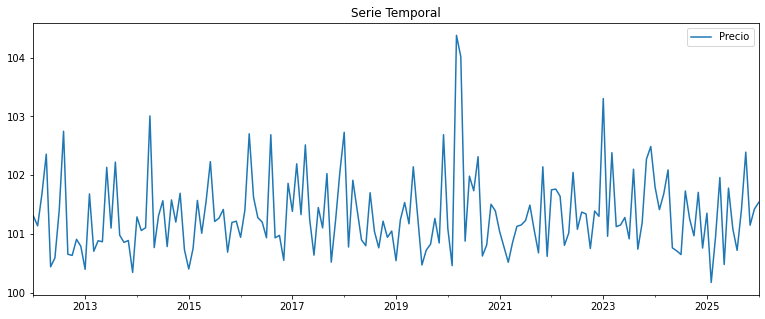

In [42]:
df11=crear_df_fin_datos(fecha1,fecha3,'MS',['Precio'],8,[0.5,100,1.2])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
0.3408943164020403


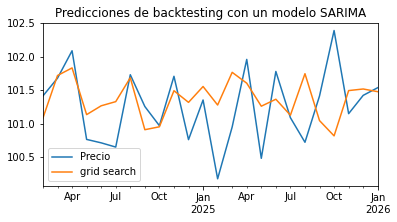

In [43]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df11_train = df11.loc[:fin_train]
df11_test  = df11.loc[fin_train:]

prediccion_autorregresivos(df11,df11_train,df11_test,fin_train)

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fe2ae91b3a0>


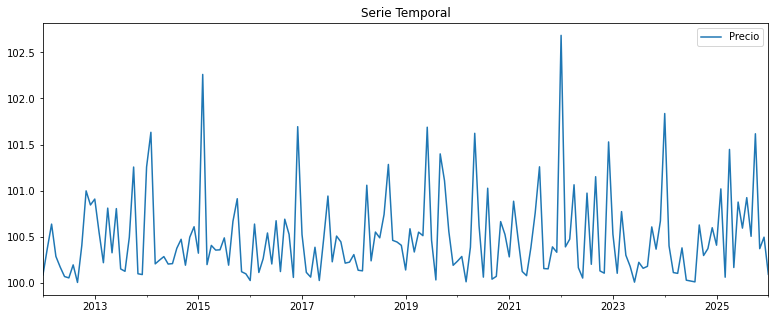

In [44]:
df12=crear_df_fin_datos(fecha1,fecha3,'MS',['Precio'],9,[100,0.5])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
0.17390142797193342


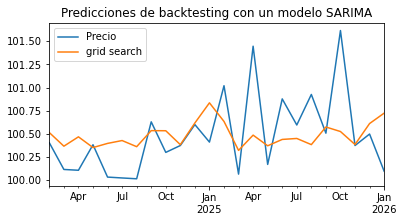

In [45]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df12_train = df12.loc[:fin_train]
df12_test  = df12.loc[fin_train:]

prediccion_autorregresivos(df12,df12_train,df12_test,fin_train)

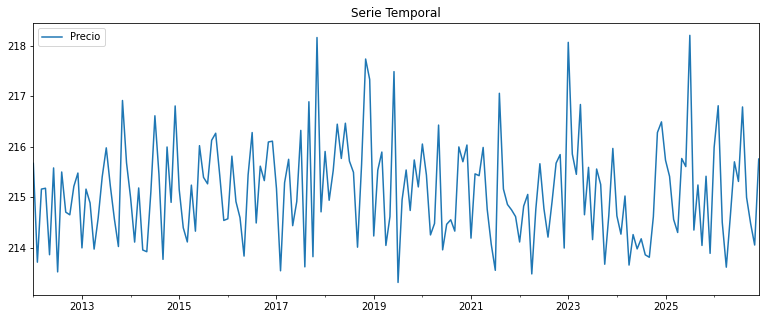

In [47]:
df13=crear_df_periodos_datos(fecha1,180,'MS',['Precio'],10,[4,213,0.5])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
1.1396499528804414


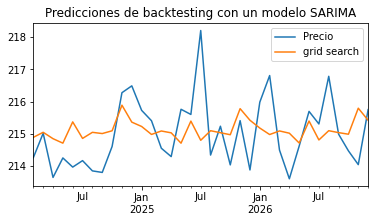

In [48]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df13_train = df13.loc[:fin_train]
df13_test  = df13.loc[fin_train:]

prediccion_autorregresivos(df13,df13_train,df13_test,fin_train)

/tmp/ipykernel_160230/3389274330.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  serie = pd.date_range(start=inicio, periods=periodos, freq=freq)


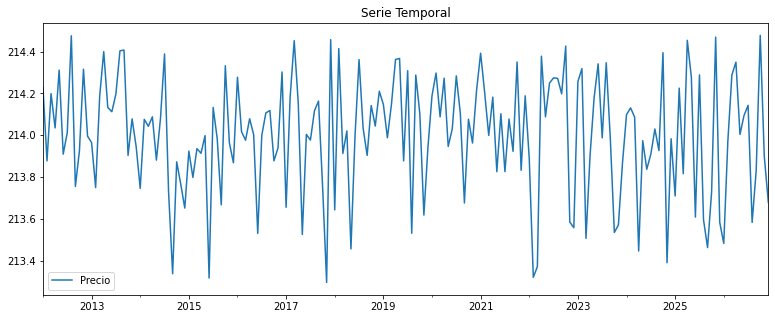

In [49]:
df14=crear_df_periodos_datos(fecha1,180,'M',['Precio'],11,[4,2,213,1.5])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
0.0995893818890749


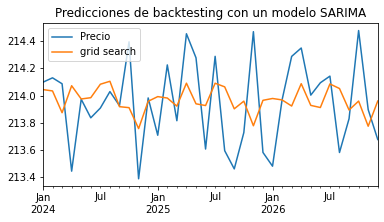

In [50]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df14_train = df14.loc[:fin_train]
df14_test  = df14.loc[fin_train:]

prediccion_autorregresivos(df14,df14_train,df14_test,fin_train)

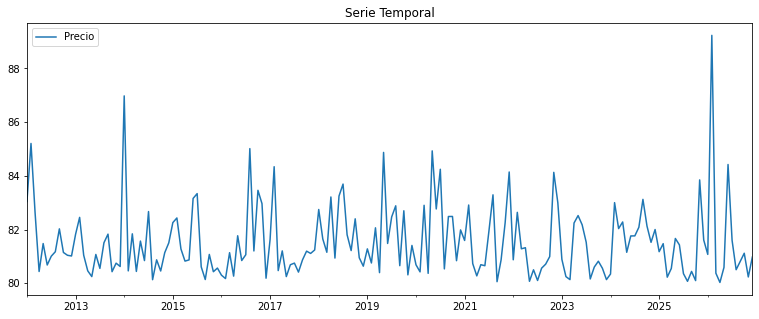

In [52]:
df15=crear_df_periodos_datos(fecha1,180,'MS',['Precio'],12,[3,80,0.5])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
2.792671567954047


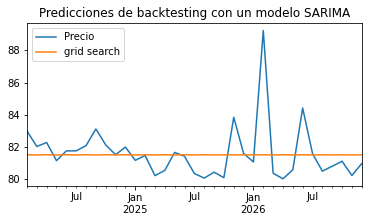

In [54]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df15_train = df15.loc[:fin_train]
df15_test  = df15.loc[fin_train:]

prediccion_autorregresivos(df15,df15_train,df15_test,fin_train)

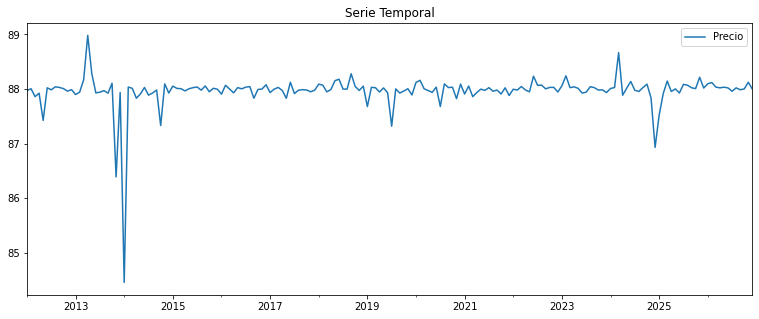

In [55]:
df16=crear_df_periodos_datos(fecha1,180,'MS',['Precio'],13,[1.25,88,0.05])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
0.0579443968770075


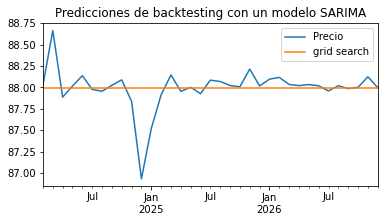

In [56]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df16_train = df16.loc[:fin_train]
df16_test  = df16.loc[fin_train:]

prediccion_autorregresivos(df16,df16_train,df16_test,fin_train)

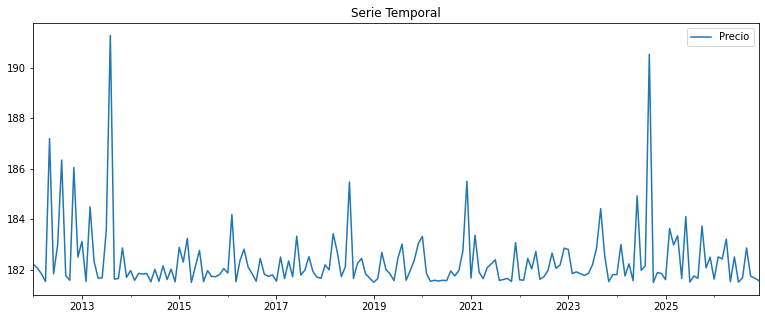

In [58]:
df17=crear_df_periodos_datos(fecha1,180,'MS',['Precio'],14,[3,180,1.5])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
3.1127095800457885


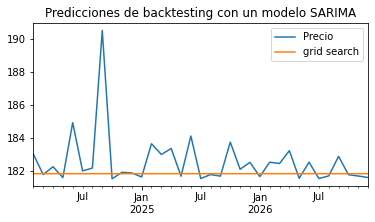

In [59]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df17_train = df17.loc[:fin_train]
df17_test  = df17.loc[fin_train:]

prediccion_autorregresivos(df17,df17_train,df17_test,fin_train)

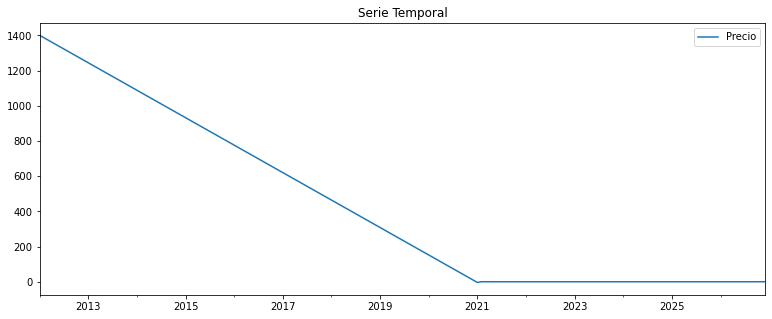

In [60]:
df18=crear_df_periodos_datos(fecha1,180,'MS',['Precio'],15,[1400,13])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
0.0


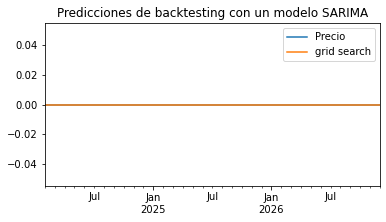

In [61]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df18_train = df18.loc[:fin_train]
df18_test  = df18.loc[fin_train:]

prediccion_autorregresivos(df18,df18_train,df18_test,fin_train)

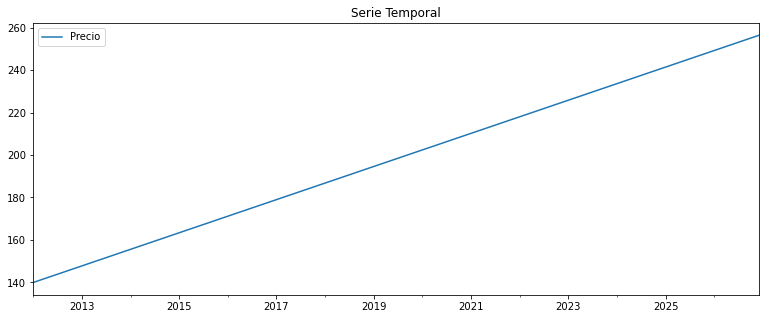

In [62]:
df19=crear_df_periodos_datos(fecha1,180,'MS',['Precio'],16,[140,0.65])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
9.231926479386469e-29


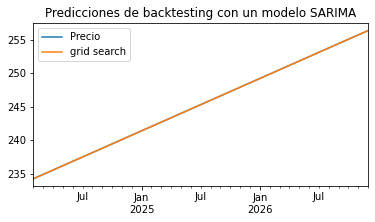

In [63]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df19_train = df19.loc[:fin_train]
df19_test  = df19.loc[fin_train:]

prediccion_autorregresivos(df19,df19_train,df19_test,fin_train)

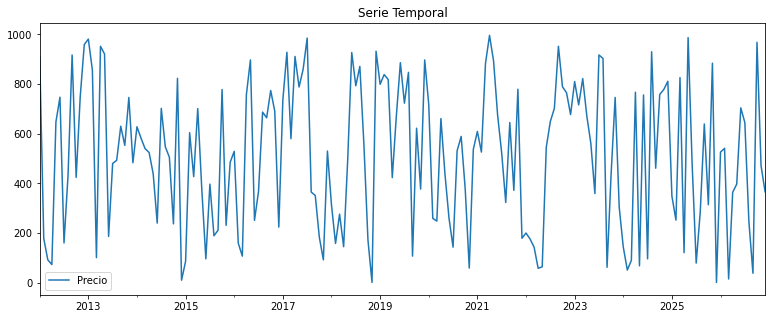

In [65]:
df20=crear_df_periodos_datos(fecha1,180,'MS',['Precio'],17,[1,1000])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
95776.02208911999


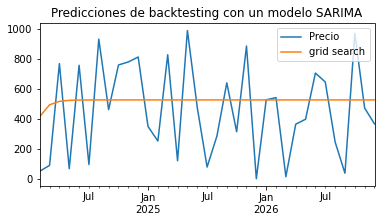

In [66]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df20_train = df20.loc[:fin_train]
df20_test  = df20.loc[fin_train:]

prediccion_autorregresivos(df20,df20_train,df20_test,fin_train)

MODELOS PERIÓDICOS:

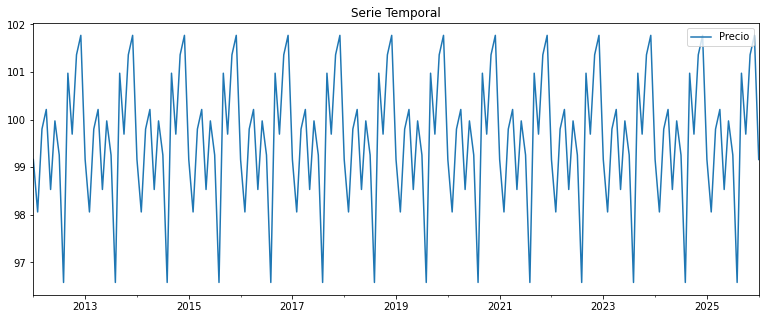

In [68]:
df21=crear_df_fin_periodicos(fecha1,fecha3,'MS',['Precio'],1,[100,1.5],12,1)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
0.0


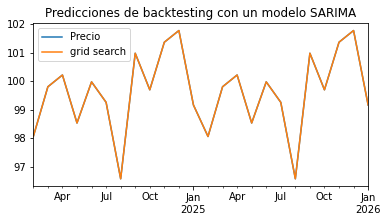

In [69]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df21_train = df21.loc[:fin_train]
df21_test  = df21.loc[fin_train:]

prediccion_autorregresivos(df21,df21_train,df21_test,fin_train)

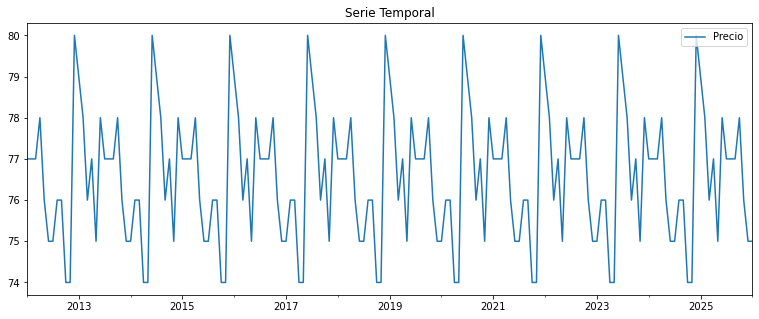

In [70]:
df22=crear_df_fin_periodicos(fecha1,fecha3,'MS',['Precio'],2,[10,0.65,70],9,2)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
1.6143898782413126


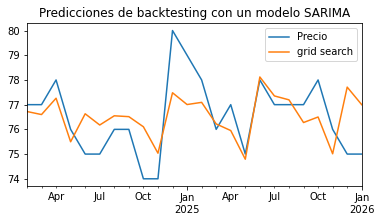

In [72]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df22_train = df22.loc[:fin_train]
df22_test  = df22.loc[fin_train:]

prediccion_autorregresivos(df22,df22_train,df22_test,fin_train)

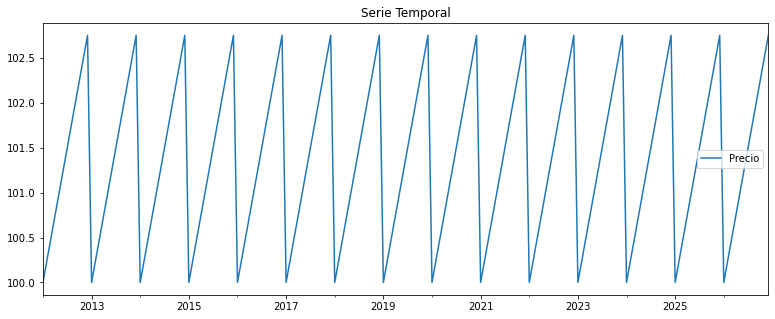

In [74]:
df23=crear_df_periodos_periodicos(fecha1,180,'MS',['Precio'],16,[100,0.25],12,1)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
0.0


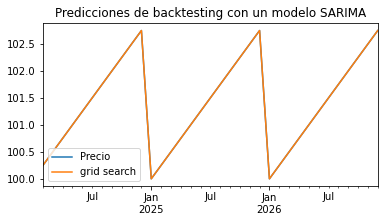

In [75]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df23_train = df23.loc[:fin_train]
df23_test  = df23.loc[fin_train:]

prediccion_autorregresivos(df23,df23_train,df23_test,fin_train)

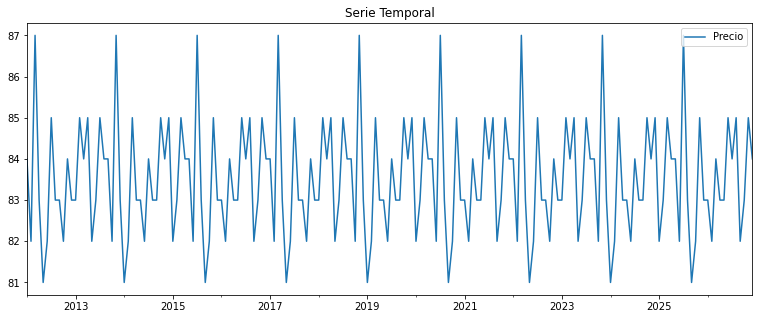

In [76]:
df24=crear_df_periodos_periodicos(fecha1,180,'MS',['Precio'],3,[3,80],9,2)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
0.950441613055768


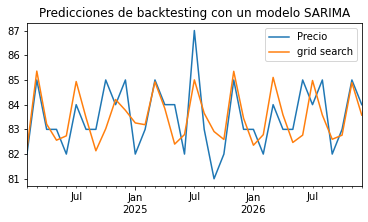

In [77]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df24_train = df24.loc[:fin_train]
df24_test  = df24.loc[fin_train:]

prediccion_autorregresivos(df24,df24_train,df24_test,fin_train)

MODELOS AUTORREGRESIVOS:

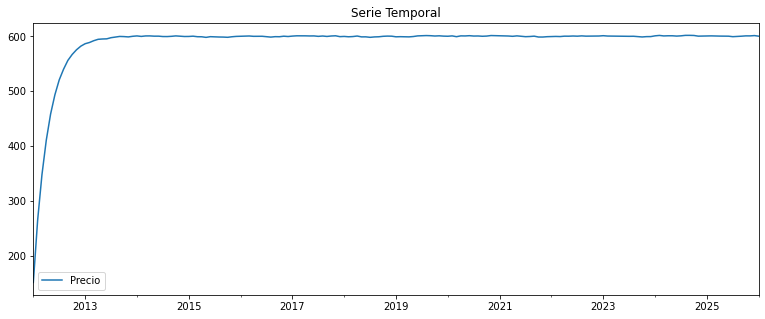

In [82]:
df25 = crear_df_fin_ARMA(fecha1,fecha3,'MS',['Precio'],150,0.6,0,[0.75]) # estacionario

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
0.38134581128975986


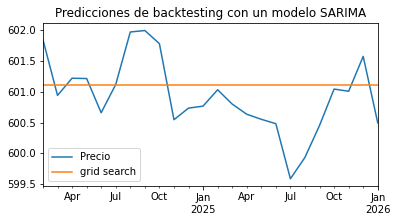

In [83]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df25_train = df25.loc[:fin_train]
df25_test  = df25.loc[fin_train:]

prediccion_autorregresivos(df25,df25_train,df25_test,fin_train)

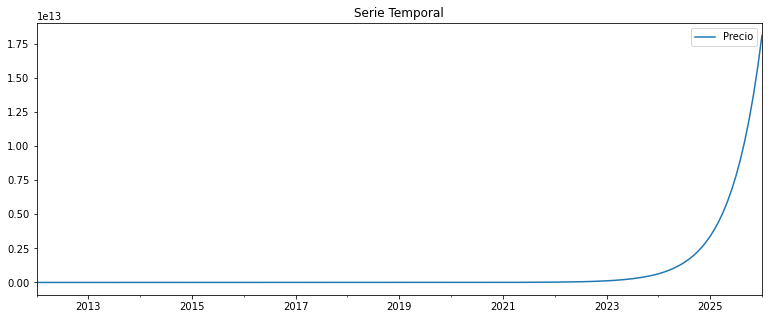

In [84]:
df26 = crear_df_fin_ARMA(fecha1,fecha3,'MS',['Precio'],150,1.25,0,[1.15]) # no estacionario

In [86]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df26_train = df26.loc[:fin_train]
df26_test  = df26.loc[fin_train:]

prediccion_autorregresivos(df26,df26_train,df26_test,fin_train)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

LinAlgError: LU decomposition error.

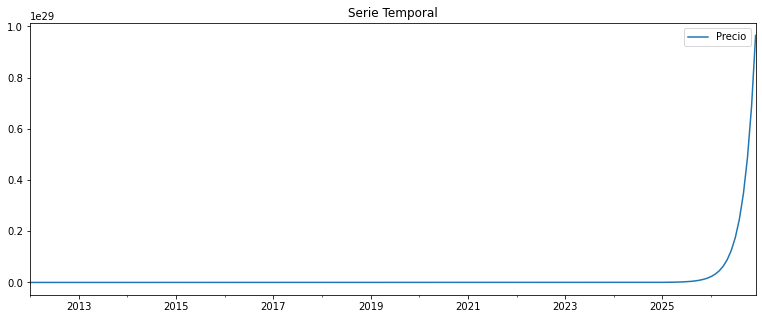

In [87]:
df27 = crear_df_periodos_ARMA(fecha1,180,'M',['Precio'],150,1.5,0,[1.05,0.5])# no estacionario

In [88]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df27_train = df27.loc[:fin_train]
df27_test  = df27.loc[fin_train:]

prediccion_autorregresivos(df27,df27_train,df27_test,fin_train)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

LinAlgError: LU decomposition error.

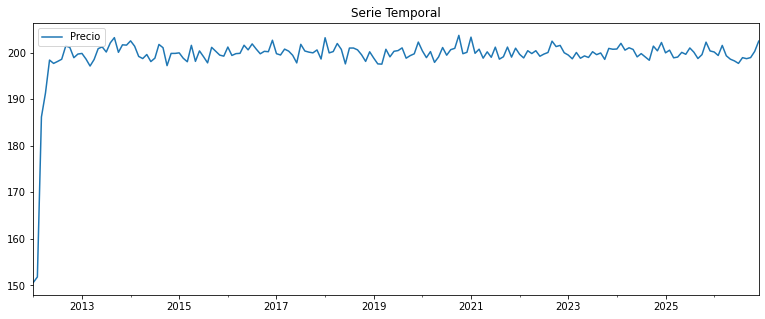

In [89]:
df28 = crear_df_periodos_ARMA(fecha1,180,'MS',['Precio'],150,1.25,0,[0.1,0.15]) # estacionario
# estacionario

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
1.6502924651015491


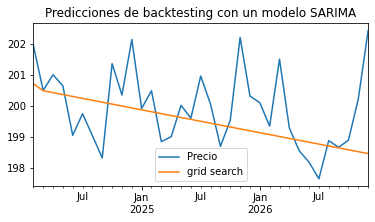

In [90]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df28_train = df28.loc[:fin_train]
df28_test  = df28.loc[fin_train:]

prediccion_autorregresivos(df28,df28_train,df28_test,fin_train)

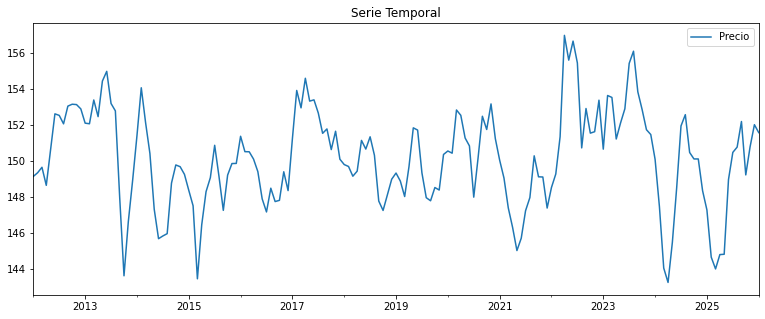

In [91]:
df29 = crear_df_fin_ARMA(fecha1,fecha3,'MS',['Precio'],150,1.5,0,teta=[1.1,0.95,0.8])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error): 
11.841151996647424


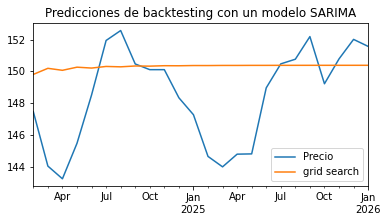

In [92]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df29_train = df29.loc[:fin_train]
df29_test  = df29.loc[fin_train:]

prediccion_autorregresivos(df29,df29_train,df29_test,fin_train)

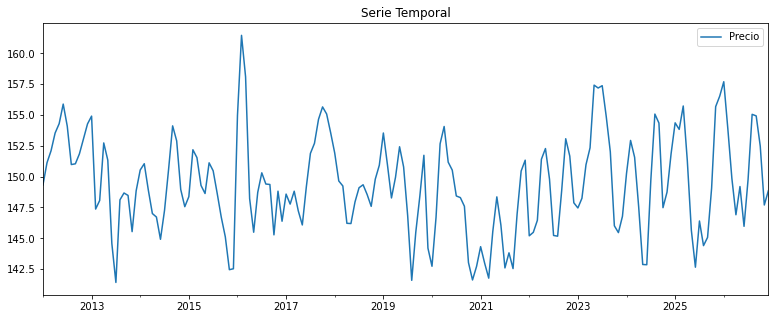

In [108]:
df30 = crear_df_periodos_ARMA(fecha1,180,'MS',['Precio'],150,2.5,0,teta=[1.08,0.8])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0             3.391891

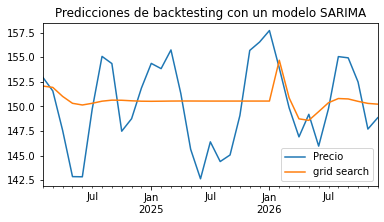

In [109]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df30_train = df30.loc[:fin_train]
df30_test  = df30.loc[fin_train:]

prediccion_autorregresivos(df30,df30_train,fin_train)

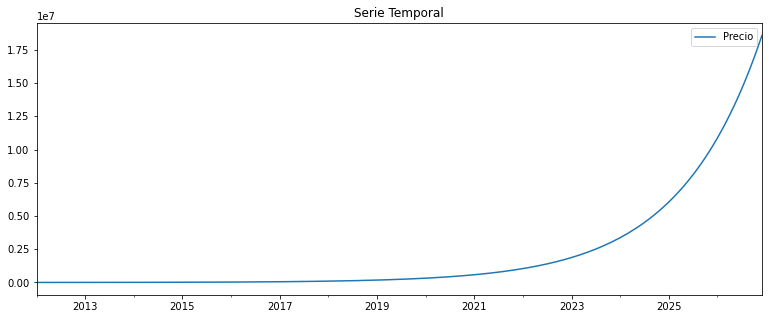

In [111]:
df31 = crear_df_periodos_ARMA(fecha1,180,'MS',['Precio'],150,2.5,0,phi=[1.05],teta=[2.8,1.56]) # no estacionario

In [112]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df31_train = df31.loc[:fin_train]
df31_test  = df31.loc[fin_train:]

prediccion_autorregresivos(df31,df31_train,fin_train)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

LinAlgError: LU decomposition error.

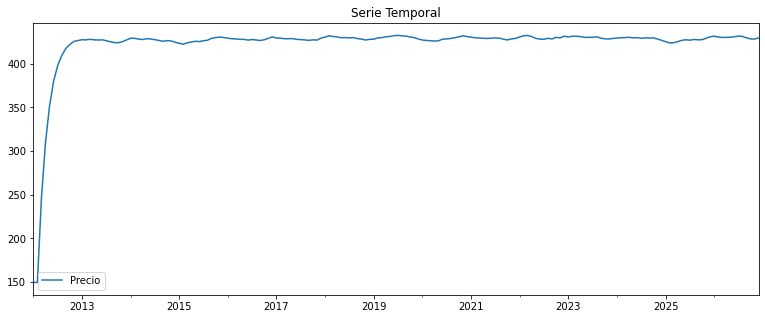

In [113]:
df32 = crear_df_periodos_ARMA(fecha1,180,'MS',['Precio'],150,0.5,0,phi=[0.65],teta=[1.10,1.4]) # estacionario

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0             2.889472

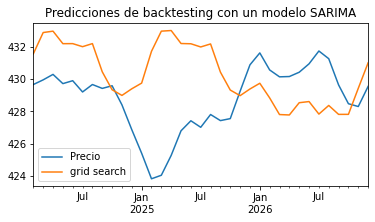

In [114]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df32_train = df32.loc[:fin_train]
df32_test  = df32.loc[fin_train:]

prediccion_autorregresivos(df32,df32_train,fin_train)

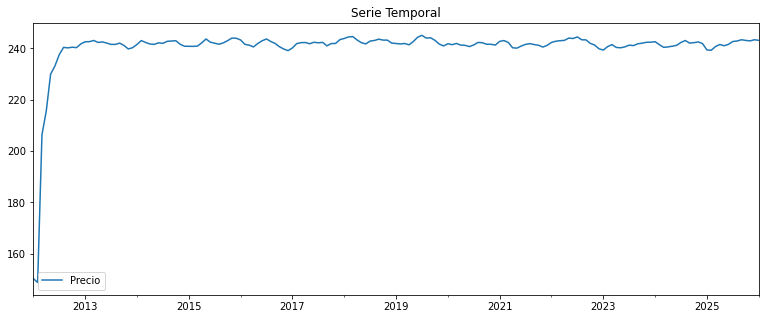

In [116]:
df33 = crear_df_fin_ARMA(fecha1,fecha3,'MS',['Precio'],150,0.65,0,phi=[0.15,0.23],teta=[1.03,0.6]) # estacionario

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0             0.857064

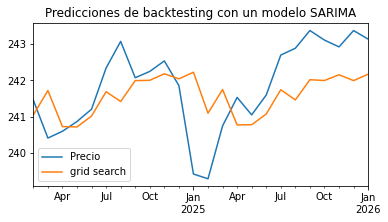

In [117]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df33_train = df33.loc[:fin_train]
df33_test  =df33.loc[fin_train:]

prediccion_autorregresivos(df33,df33_train,fin_train)

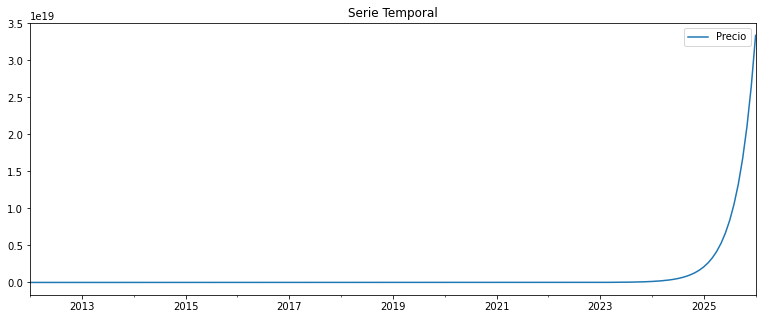

In [119]:
df34 = crear_df_fin_ARMA(fecha1,fecha3,'MS',['Precio'],150,2.5,0,phi=[1.1,0.2],teta=[1.8,1.3]) # no estacionario

In [120]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df34_train = df34.loc[:fin_train]
df34_test  = df34.loc[fin_train:]

prediccion_autorregresivos(df34,df34_train,fin_train)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

LinAlgError: LU decomposition error.

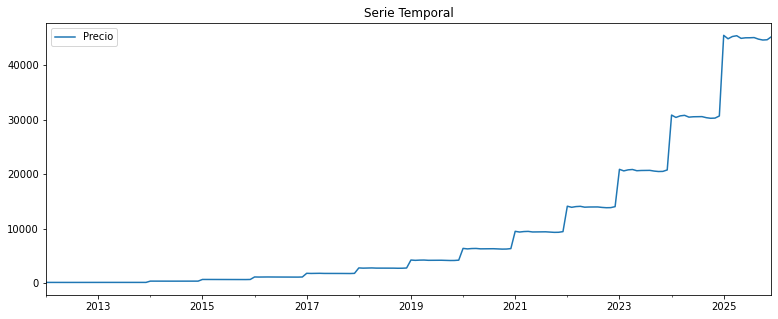

In [122]:
df35 = crear_df_fin_ARMA(fecha1,fecha3,'M',['Precio'],150,2.5,12,phi=[1.3,0.25]) # no estacionario

In [123]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df35_train = df35.loc[:fin_train]
df35_test  = df35.loc[fin_train:]

prediccion_autorregresivos(df35,df35_train,fin_train)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

LinAlgError: LU decomposition error.

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6ed9df9ca0>


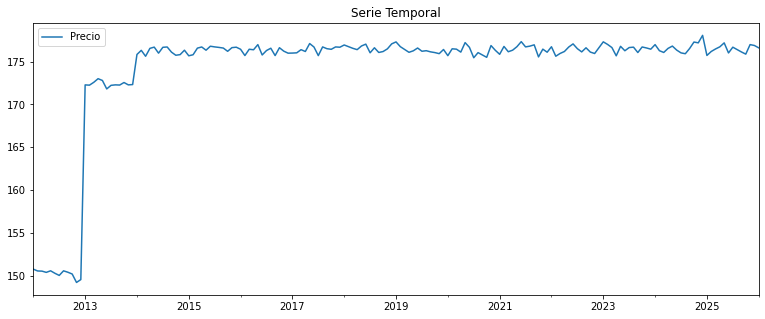

In [138]:
dfh = crear_df_fin_ARMA(fecha1,fecha3,'MS',['Precio'],150,0.45,12,phi=[0.15]) # estacionario

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0              0.55451

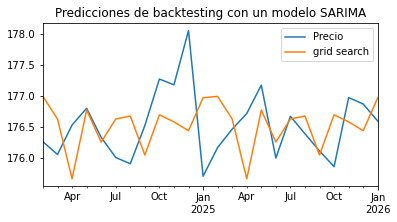

In [139]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
dfh_train = dfh.loc[:fin_train]
dfh_test  = dfh.loc[fin_train:]

prediccion_autorregresivos(dfh,dfh_train,fin_train)

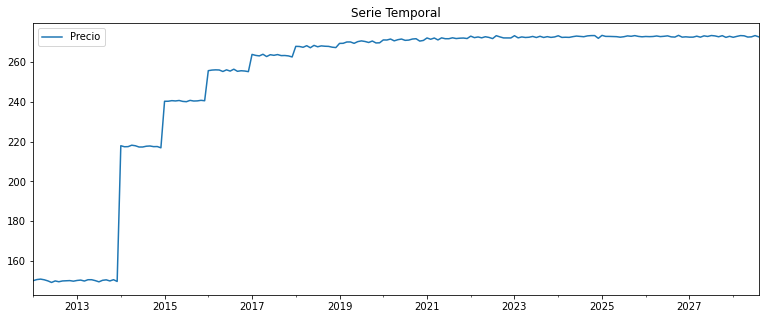

In [136]:
df36 = crear_df_periodos_ARMA(fecha1,200,'MS',['Precio'],150,0.35,12,phi=[0.34,0.11]) # estacionario

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0             0.345313

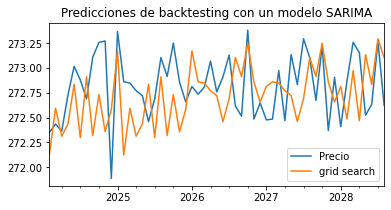

In [137]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df36_train = df36.loc[:fin_train]
df36_test  = df36.loc[fin_train:]

prediccion_autorregresivos(df36,df36_train,fin_train)

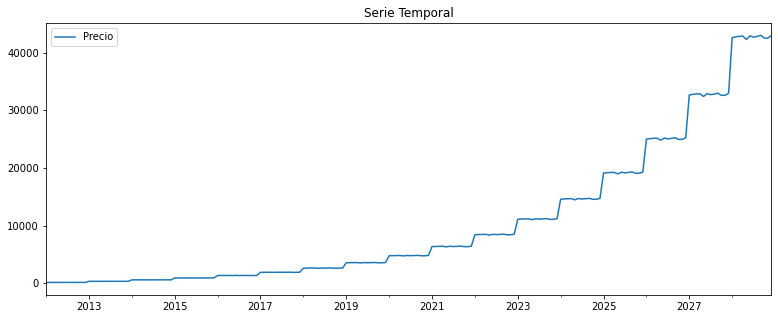

In [134]:
df37 = crear_df_periodos_ARMA(fecha1,204,'MS',['Precio'],150,2.5,12,phi=[1.3]) # no estacionario

In [135]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df37_train = df37.loc[:fin_train]
df37_test  = df37.loc[fin_train:]

prediccion_autorregresivos(df37,df37_train,fin_train)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

LinAlgError: LU decomposition error.

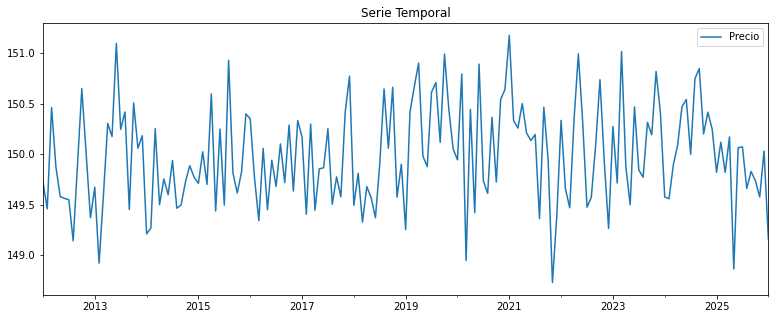

In [133]:
df38 = crear_df_fin_ARMA(fecha1,fecha3,'MS',['Precio'],150,0.5,12,teta=[0.03])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0             0.314747

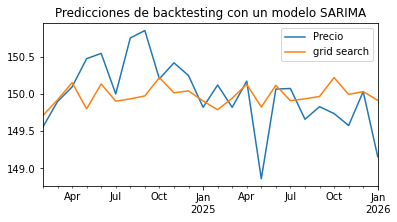

In [140]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df38_train = df38.loc[:fin_train]
df38_test  = df38.loc[fin_train:]

prediccion_autorregresivos(df38,df38_train,fin_train)

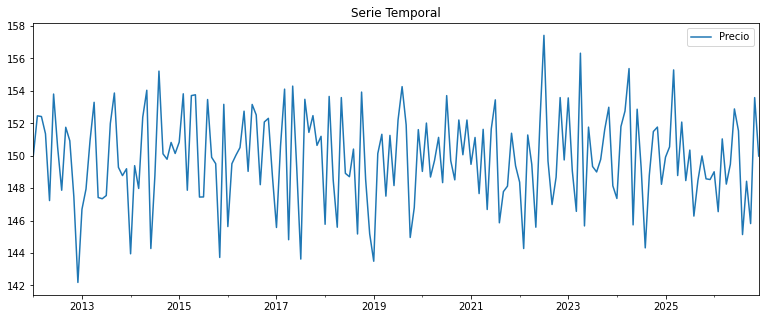

In [142]:
df39 = crear_df_periodos_ARMA(fecha1,180,'MS',['Precio'],150,2.5,12,teta=[0.3])

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0             2.126563

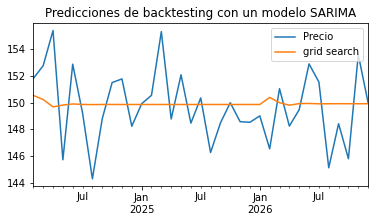

In [143]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df39_train = df39.loc[:fin_train]
df39_test  = df39.loc[fin_train:]

prediccion_autorregresivos(df39,df39_train,fin_train)

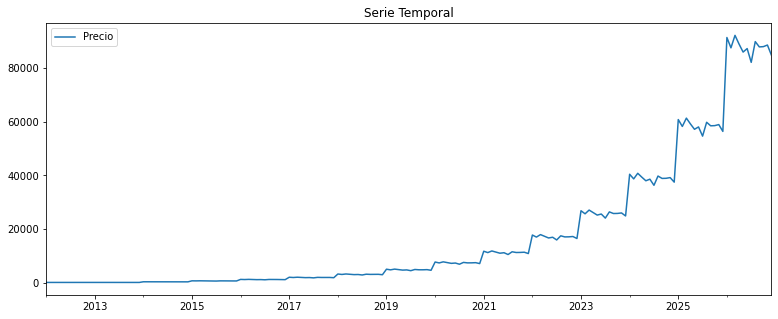

In [145]:
df40 = crear_df_periodos_ARMA(fecha1,180,'MS',['Precio'],150,2.5,12,phi=[1.5],teta=[2.8,1.56]) # no estacionario

In [146]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df40_train = df40.loc[:fin_train]
df40_test  = df40.loc[fin_train:]

prediccion_autorregresivos(df40,df40_train,fin_train)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

LinAlgError: LU decomposition error.

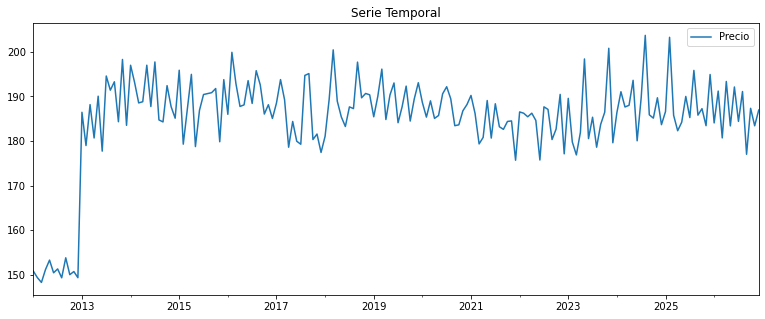

In [147]:
df41 = crear_df_periodos_ARMA(fecha1,180,'M',['Precio'],150,1.5,6,phi=[0.2],teta=[2.8,1.56]) # estacionario

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0             4.760063

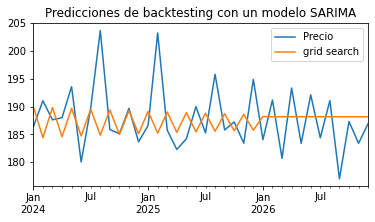

In [148]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df41_train = df41.loc[:fin_train]
df41_test  = df41.loc[fin_train:]

prediccion_autorregresivos(df41,df41_train,fin_train)

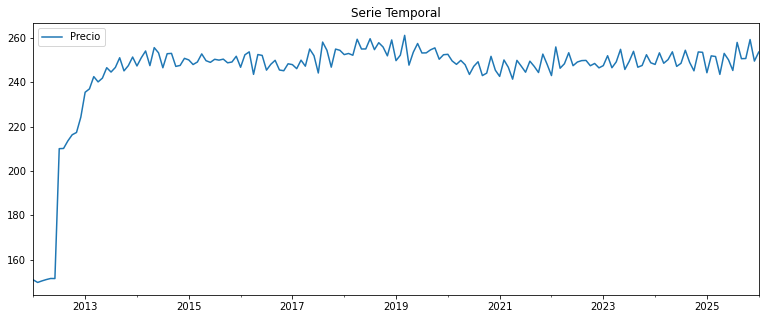

In [150]:
df42 = crear_df_fin_ARMA(fecha1,fecha3,'MS',['Precio'],150,1.5,3,phi=[0.15,0.25],teta=[1.8,0.56]) # estacionario

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0             2.374995

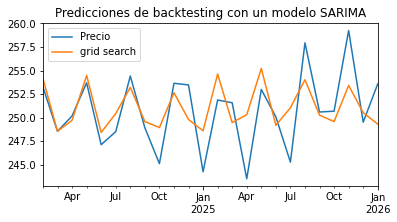

In [151]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df42_train = df42.loc[:fin_train]
df42_test  = df42.loc[fin_train:]

prediccion_autorregresivos(df42,df42_train,fin_train)

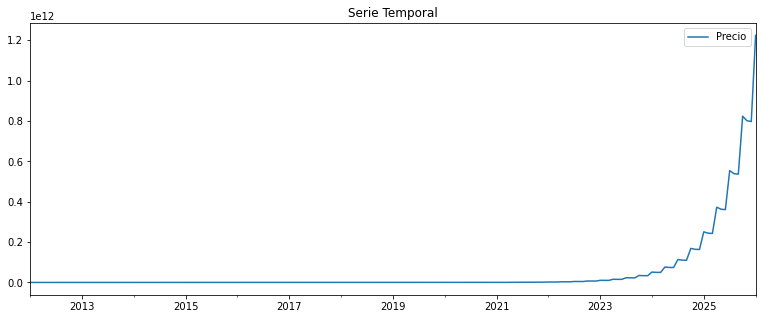

In [153]:
df43 = crear_df_fin_ARMA(fecha1,fecha3,'MS',['Precio'],150,2.5,3,phi=[1.15,0.5],teta=[1.8,0.56]) # no estacionario

In [154]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df43_train = df43.loc[:fin_train]
df43_test  = df43.loc[fin_train:]

prediccion_autorregresivos(df43,df43_train,fin_train)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

LinAlgError: LU decomposition error.

CAMBIO EN LAS DISTRIBUCIONES: 

In [155]:
columna=['Precio']

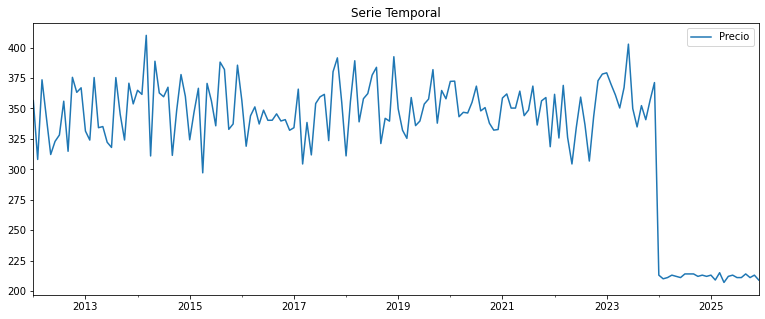

In [156]:
df44 = crear_df_fin_DRIFT(fecha1,fecha3,'M',columna,paramsD1,paramsD2,1,144)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0            138.05732

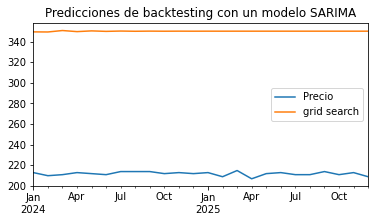

In [157]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df44_train = df44.loc[:fin_train]
df44_test  = df44.loc[fin_train:]

prediccion_autorregresivos(df44,df44_train,fin_train)

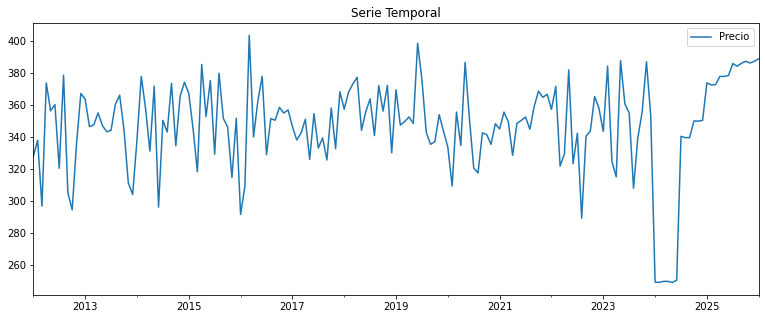

In [159]:
df45 = crear_df_fin_DRIFT(fecha1,fecha3,'MS',columna,paramsD1,params_ARMA1,2,144)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0            95.551756

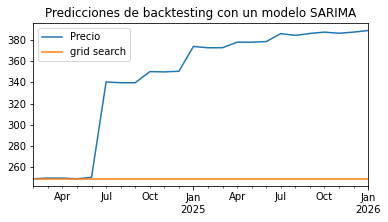

In [160]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df45_train = df45.loc[:fin_train]
df45_test  = df45.loc[fin_train:]

prediccion_autorregresivos(df45,df45_train,fin_train)

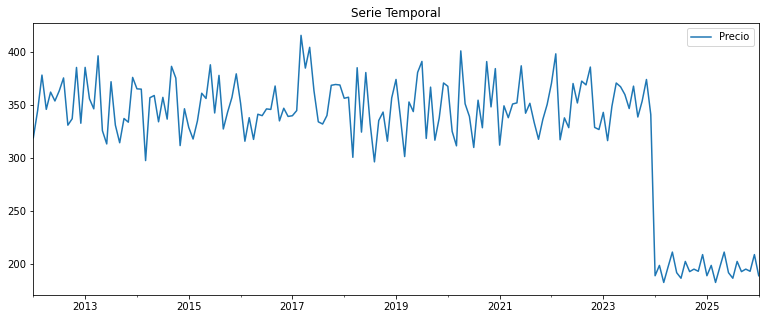

In [162]:
df46 = crear_df_fin_DRIFT(fecha1,fecha3,'MS',columna,paramsD1,params_per1,3,144)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0            95.551756

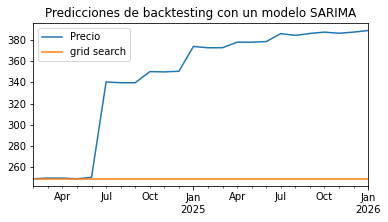

In [163]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df46_train = df46.loc[:fin_train]
df46_test  = df46.loc[fin_train:]

prediccion_autorregresivos(df45,df45_train,fin_train)

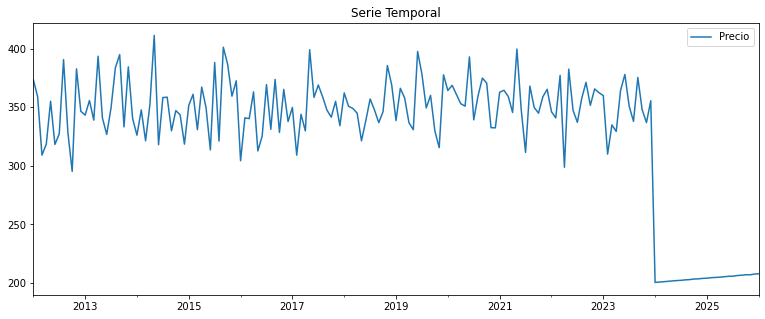

In [165]:
df47 = crear_df_fin_DRIFT(fecha1,fecha3,'MS',columna,paramsD1,params_tend1,4,144)

In [166]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df47_train = df47.loc[:fin_train]
df47_test  = df47.loc[fin_train:]

prediccion_autorregresivos(df47,df47_train,fin_train)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

LinAlgError: LU decomposition error.

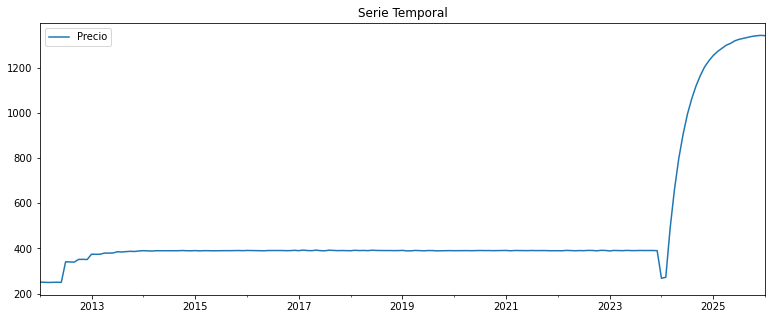

In [168]:
df48 = crear_df_fin_DRIFT(fecha1,fecha3,'MS',columna,params_ARMA1,params_ARMA2,5,144)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0           858.396413

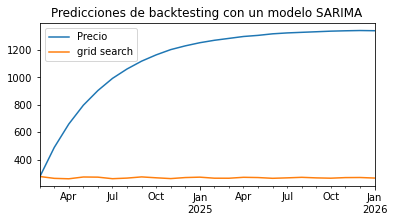

In [169]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df48_train = df48.loc[:fin_train]
df48_test  = df48.loc[fin_train:]

prediccion_autorregresivos(df48,df48_train,fin_train)

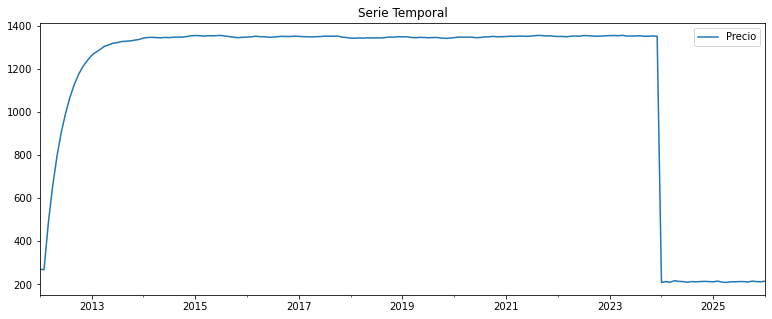

In [171]:
df49 = crear_df_fin_DRIFT(fecha1,fecha3,'MS',columna,params_ARMA2,paramsD2,6,144)

In [172]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df49_train = df49.loc[:fin_train]
df49_test  = df49.loc[fin_train:]

prediccion_autorregresivos(df49,df49_train,fin_train)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

LinAlgError: LU decomposition error.

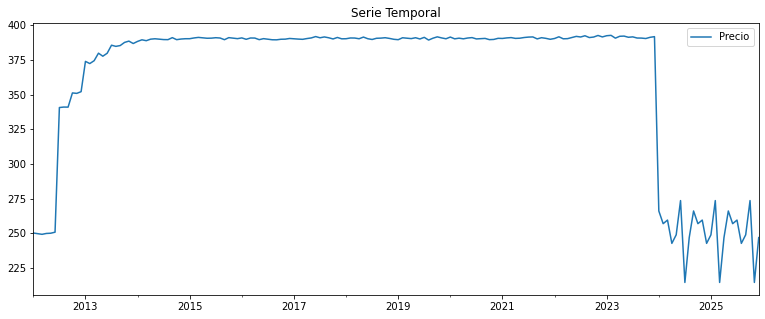

In [173]:
df50 = crear_df_fin_DRIFT(fecha1,fecha3,'M',columna,params_ARMA1,params_per2,7,144)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0           140.882955

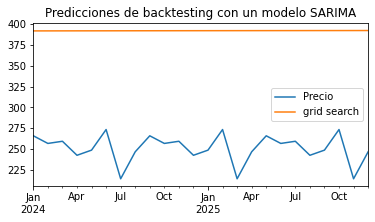

In [174]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df50_train = df50.loc[:fin_train]
df50_test  = df50.loc[fin_train:]

prediccion_autorregresivos(df50,df50_train,fin_train)

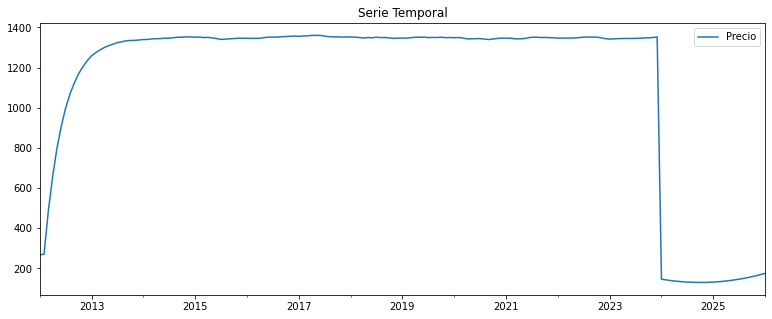

In [176]:
df51= crear_df_fin_DRIFT(fecha1,fecha3,'MS',columna,params_ARMA2,params_tend2,8,144)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0            13.715287

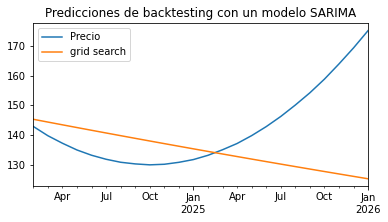

In [177]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df51_train = df51.loc[:fin_train]
df51_test  = df51.loc[fin_train:]

prediccion_autorregresivos(df51,df51_train,fin_train)

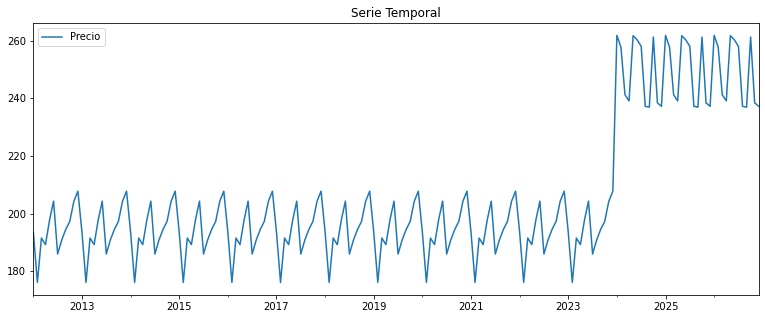

In [179]:
df52= crear_df_periodos_DRIFT(fecha1,180,'MS',columna,params_per1,params_per2,9,144)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0            37.490987

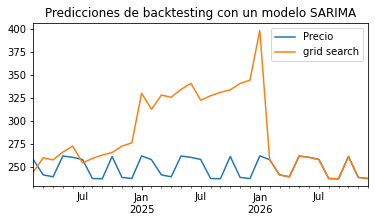

In [180]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df52_train = df52.loc[:fin_train]
df52_test  = df52.loc[fin_train:]

prediccion_autorregresivos(df52,df52_train,fin_train)

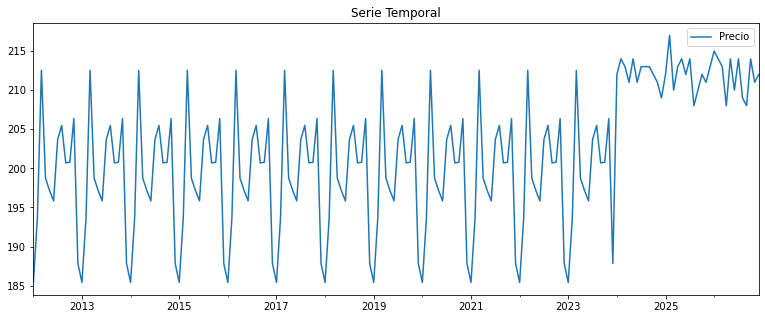

In [181]:
df53= crear_df_periodos_DRIFT(fecha1,180,'MS',columna,params_per1,paramsD2,10,144)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0             2.142857

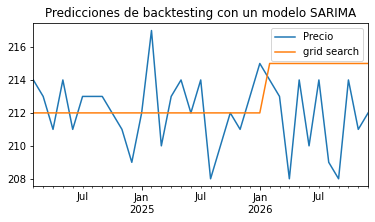

In [182]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df53_train = df53.loc[:fin_train]
df53_test  = df53.loc[fin_train:]

prediccion_autorregresivos(df53,df53_train,fin_train)

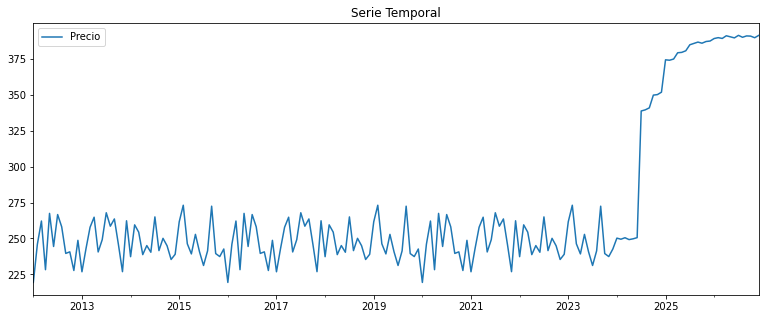

In [184]:
df54= crear_df_periodos_DRIFT(fecha1,180,'MS',columna,params_per2,params_ARMA1,11,144)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0            67.687175

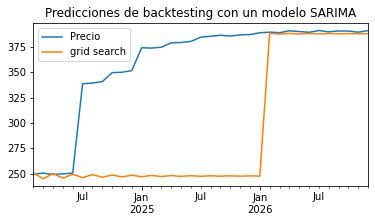

In [185]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df54_train = df54.loc[:fin_train]
df54_test  = df54.loc[fin_train:]

prediccion_autorregresivos(df54,df54_train,fin_train)

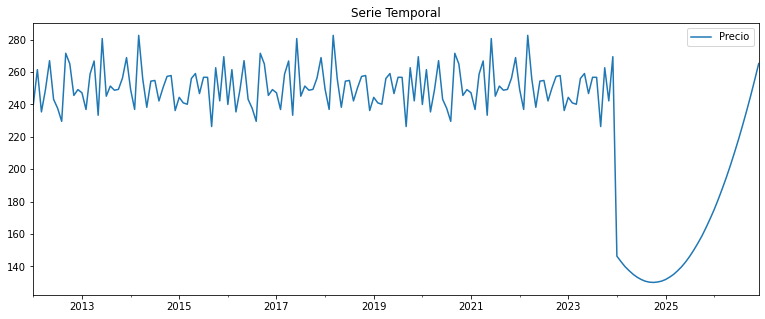

In [187]:
df55 = crear_df_periodos_DRIFT(fecha1,180,'MS',columna,params_per2,params_tend2,12,144)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0            22.457453

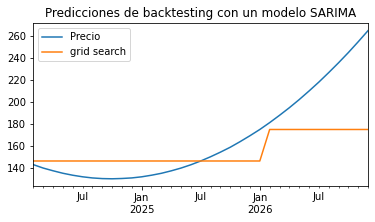

In [188]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df55_train = df55.loc[:fin_train]
df55_test  = df55.loc[fin_train:]

prediccion_autorregresivos(df55,df55_train,fin_train)

/tmp/ipykernel_127289/3389274330.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  serie = pd.date_range(start=inicio, periods=periodos, freq=freq)


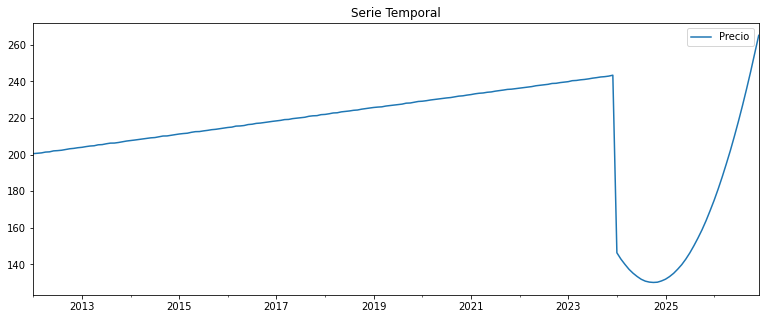

In [189]:
df56= crear_df_periodos_DRIFT(fecha1,180,'M',columna,params_tend1,params_tend2,13,144)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0             85.70247

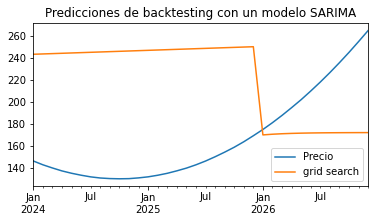

In [190]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df56_train = df56.loc[:fin_train]
df56_test  = df56.loc[fin_train:]

prediccion_autorregresivos(df56,df56_train,fin_train)

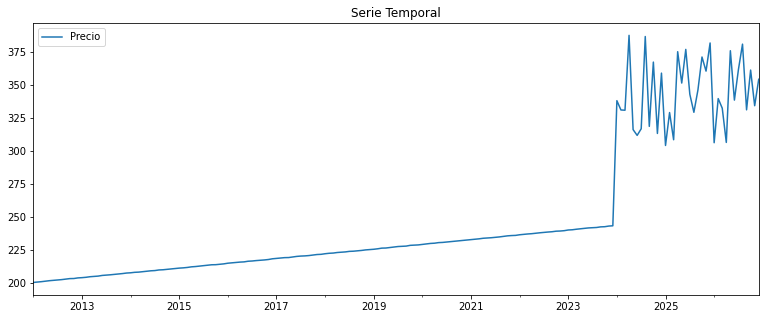

In [196]:
df57 = crear_df_periodos_DRIFT(fecha1,180,'MS',columna,params_tend1,paramsD1,14,144)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0            22.900186

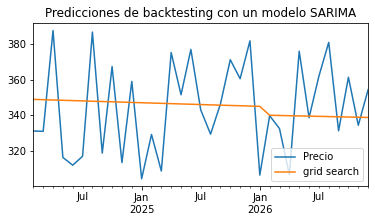

In [198]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df57_train = df57.loc[:fin_train]
df57_test  = df57.loc[fin_train:]

prediccion_autorregresivos(df57,df57_train,fin_train)

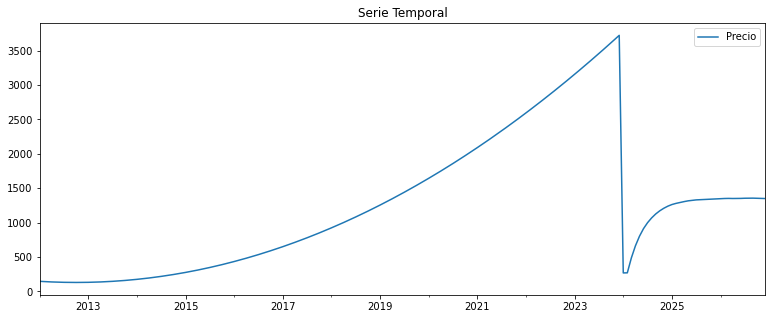

In [192]:
df58 = crear_df_periodos_DRIFT(fecha1,180,'MS',columna,params_tend2,params_ARMA2,15,144)

In [199]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df58_train = df58.loc[:fin_train]
df58_test  = df58.loc[fin_train:]

prediccion_autorregresivos(df58,df58_train,fin_train)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

LinAlgError: LU decomposition error.

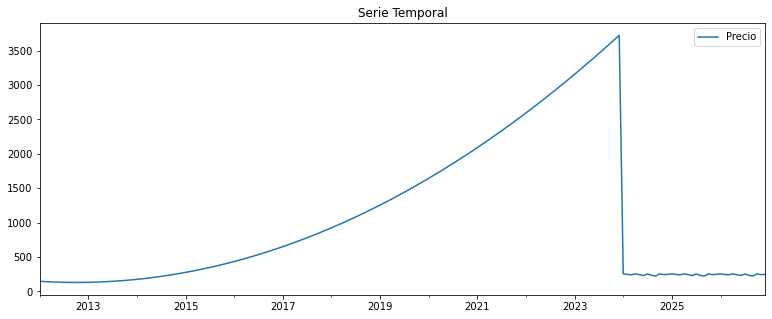

In [194]:
df59 = crear_df_periodos_DRIFT(fecha1,180,'MS',columna,params_tend2,params_per2,16,144)

Number of models compared: 42.


params grid:   0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Metrica (mean absolute error) del modelo grid search:


mean_absolute_error
0            11.273589

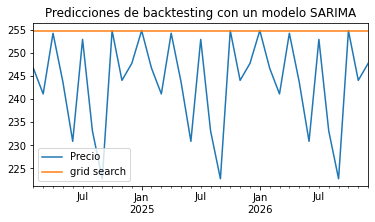

In [200]:
# División en train y test:
fin_train = '2024-01-01 23:59:59'
fin_val = '2026-01-01 23:59:59'
df59_train = df59.loc[:fin_train]
df59_test  = df59.loc[fin_train:]

prediccion_autorregresivos(df59,df59_train,fin_train)